In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [2]:
ticker = '^FCHI'
file = 'D:/Users/masoodw/ML_FINANCE/python/WEB_PROJECT/ASSETBOX/ASSETSIGHTAPP/FORECASTUPDATE/data/index_price.csv'
df_quotes = pd.read_csv(file, sep = ';')
df_quotes.index = pd.to_datetime(df_quotes.Datetime)
df_data = df_quotes[df_quotes['Symbol']==ticker]

In [3]:
df_data

,Datetime,Open,High,Low,Close,Volume,Symbol,Adj_Close
Datetime,,,,,,,,
2010-01-04 09:00:00,2010-01-04 09:00:00,3952.209961,4013.969971,3950.610107,4013.969971,113396000.0,^FCHI,4013.969971
2010-01-05 09:00:00,2010-01-05 09:00:00,4012.429932,4028.340088,3993.330078,4012.909912,129518600.0,^FCHI,4012.909912
2010-01-06 09:00:00,2010-01-06 09:00:00,4014.449951,4022.939941,3996.800049,4017.669922,110087000.0,^FCHI,4017.669922
2010-01-07 09:00:00,2010-01-07 09:00:00,4005.959961,4032.239990,3983.899902,4024.800049,118430400.0,^FCHI,4024.800049
2010-01-08 09:00:00,2010-01-08 09:00:00,4042.639893,4051.409912,4013.340088,4045.139893,131783200.0,^FCHI,4045.139893
...,...,...,...,...,...,...,...,...
2020-08-10 09:00:00,2020-08-10 09:00:00,4905.270020,4937.629883,4878.580078,4909.509766,62044500.0,^FCHI,4909.509766
2020-08-11 09:00:00,2020-08-11 09:00:00,4952.410156,5052.120117,4949.049805,5027.990234,97809400.0,^FCHI,5027.990234
2020-08-12 09:00:00,2020-08-12 09:00:00,5017.729980,5096.529785,5010.799805,5073.310059,76792800.0,^FCHI,5073.310059


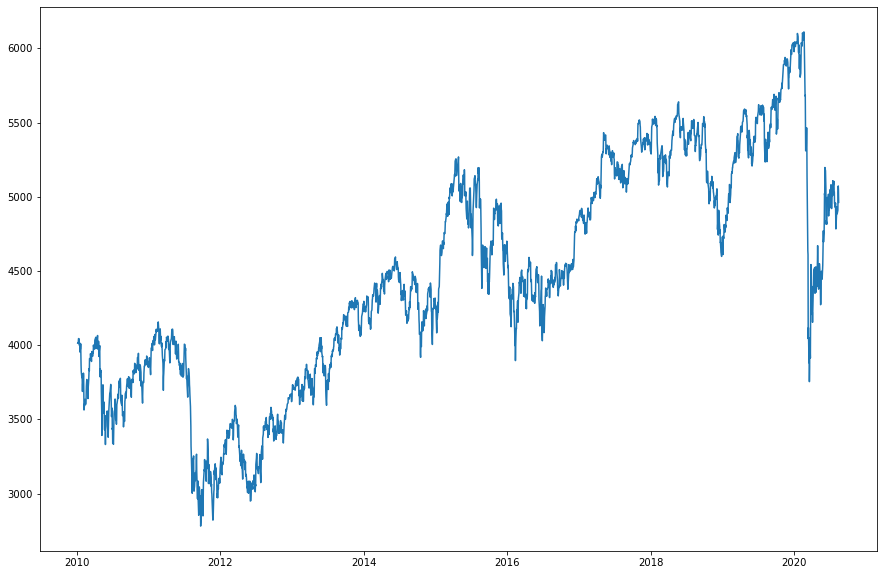

In [4]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df_data.index, df_data.Adj_Close)

### Lets drop the market crash due to corona lockdown

In [5]:
df_data = df_data[df_data['Datetime']<"2020-02"]

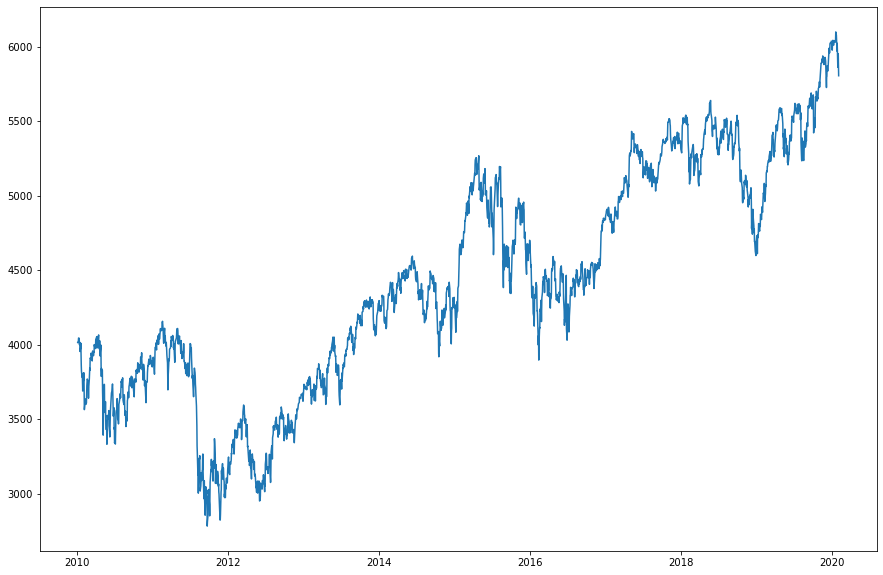

In [6]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df_data.index, df_data.Adj_Close)

In [7]:
df_X = df_data.dropna(inplace=True)
df_X = df_data.drop(['Datetime', 'Close', 'Volume', 'Symbol', 'Adj_Close'], axis=1)
df_y = df_data['Close']
df_X.shape, df_y.shape

c:\programdata\anaconda3\envs\asigmo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


((2576, 3), (2576,))

In [8]:
df_data.isna().sum()

Datetime     0
Open         0
High         0
Low          0
Close        0
Volume       0
Symbol       0
Adj_Close    0
dtype: int64

In [9]:
test_window = 7 ### days
max_rows = df_X.shape[0]

df_train_X = df_X[0:max_rows-test_window]
df_test_X = df_X[max_rows-test_window:max_rows]
df_train_X.shape, df_test_X.shape

df_train_y = df_y[0:max_rows-test_window]
df_test_y = df_y[max_rows-test_window:max_rows]

df_train_X.shape, df_train_y.shape, df_test_X.shape, df_test_y.shape


((2569, 3), (2569,), (7, 3), (7,))

### Lets take the example from the book and see how good it did

In [35]:
# Kernel with parameters given in GPML book
k1 = 66.0**2 * RBF(length_scale=67.0)  # long term smooth rising trend
k2 = 2.4**2 * RBF(length_scale=90.0) \
    * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
# medium term irregularity
k3 = 0.66**2 \
    * RationalQuadratic(length_scale=1.2, alpha=0.1)
k4 = 0.18**2 * RBF(length_scale=0.134) \
    + WhiteKernel(noise_level=0.19**2)  # noise terms
kernel_gpml = k1 + k3 + k4 #+ k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0.1,
                              optimizer=None, normalize_y=True)
gp.fit(df_train_X, df_train_y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


GPML kernel: 66**2 * RBF(length_scale=67) + 0.66**2 * RationalQuadratic(alpha=0.1, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -3634.900


In [36]:
#y_pred, y_std = gp.predict(df_test_X, return_std=True)
y_pred = gp.predict(df_test_X, return_std=False)

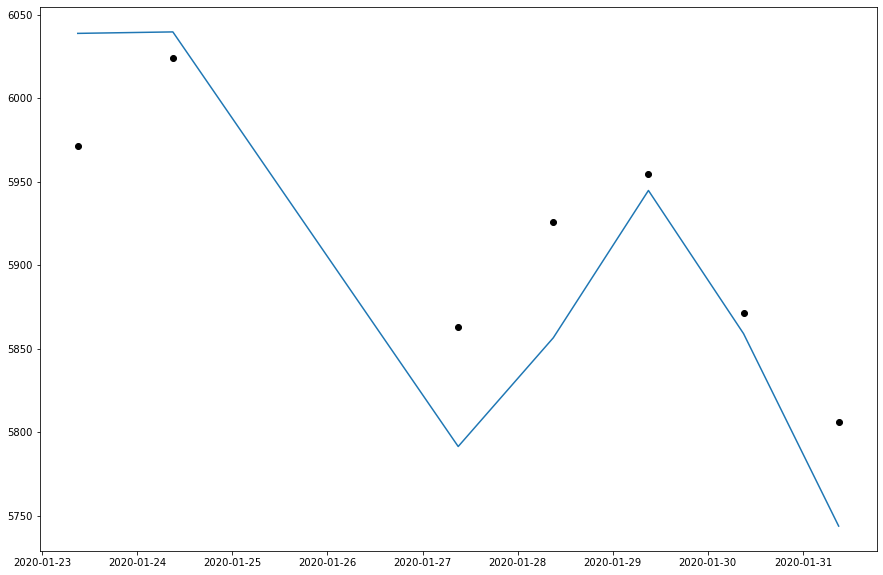

In [37]:
# Illustration
fig = plt.figure(figsize=(15, 10))
plt.scatter(df_test_y.index, df_test_y.values, c='k')
plt.plot(df_test_y.index, y_pred)

In [38]:
y_pred-df_test_y.values

array([ 67.16733692,  15.57723245, -71.48725125, -69.16392152,
       -10.01635588, -12.63132742, -62.47562526])

In [39]:
### percentage drift
(y_pred-df_test_y.values)/df_test_y.values*100

array([ 1.12474378,  0.25857505, -1.21929059, -1.16716207, -0.16820387,
       -0.21511959, -1.07598981])

In [40]:
mean_squared_error(y_pred, df_test_y.values)

2687.3225743595144

In [41]:
# Kernel with optimized parameters
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, np.inf))  # noise terms
kernel_gpml = k1 + k3 + k4 #+ k2 + k3 + k4


gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0.1,
                              optimizer=None, normalize_y=True)
gp.fit(df_train_X, df_train_y)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))


GPML kernel: 50**2 * RBF(length_scale=50) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
Log-marginal-likelihood: -4337.545


In [42]:
#y_pred, y_std = gp.predict(df_test_X, return_std=True)
y_pred = gp.predict(df_test_X, return_std=False)

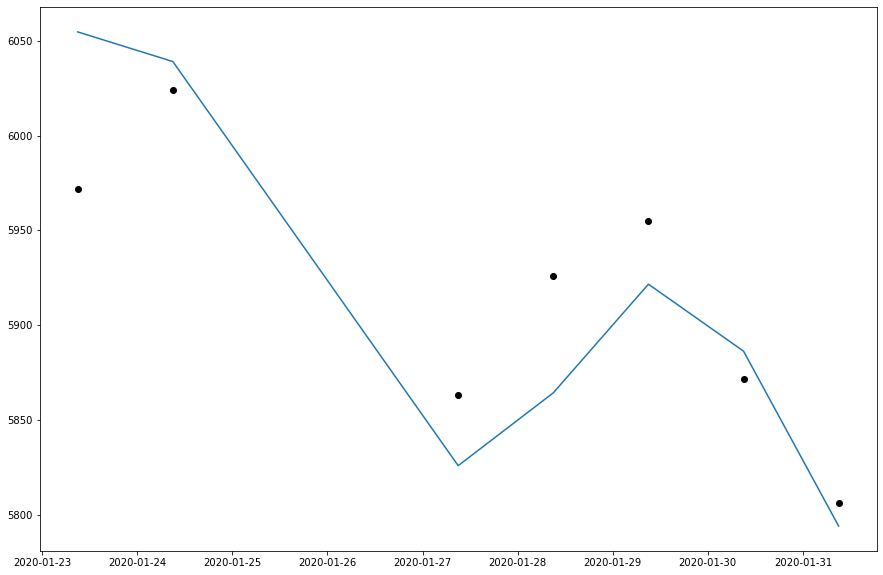

In [43]:
# Illustration
fig = plt.figure(figsize=(15, 10))
plt.scatter(df_test_y.index, df_test_y.values, c='k')
plt.plot(df_test_y.index, y_pred)

In [44]:
y_pred-df_test_y.values

array([ 82.8618323 ,  14.75778983, -37.09510701, -61.49753954,
       -33.26474278,  14.52886744, -12.28242355])

In [45]:
### percentage drift
(y_pred-df_test_y.values)/df_test_y.values*100

array([ 1.38755435,  0.24497267, -0.63269624, -1.03778956, -0.5586122 ,
        0.24743591, -0.2115347 ])

In [46]:
mean_squared_error(y_pred, df_test_y.values)

1958.6227108227238